## Load datasets

SUMMARY OF CHANGES FROM V1
- XGBoost Hyper-Parameters are tuned using HyperOpt a Bayesian Approach
- Train-Test Split Introduced (Could use CV K-fold to decide optimal split in future) 
- Some ideas: Scaling and Encoding, try different solutions 
- Monotonic Constraints
- Check out ANN for prediction: MLP Regressor

In [1]:
import pandas as pd
import sklearn as sk
import plotly as pl
import matplotlib
import matplotlib.pyplot as plt
import math
import patsy as patsy
import pickle
import statsmodels.api as sm
import numpy as np 
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error
import re
import nltk
#nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
stop_words = stopwords.words('English')
import textblob
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
import collections
from textblob import TextBlob, Word


import functions as f ## imports all the functions that are in a separate file to keep this file cleaner

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewtobin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dftrain = pd.read_csv("/Users/andrewtobin/College/final_year/FYP/House_pricing_dataset-master/dataset_csv/train.csv",index_col='ad_id')
dftest  = pd.read_csv( "/Users/andrewtobin/College/final_year/FYP/House_pricing_dataset-master/dataset_csv/test.csv",index_col='ad_id')

# Q1 Predicting Price

## Data Cleaning and Prep

In [3]:
dftrain = f.prep_data(dftrain) ## prepping the data
## DATA Prep: 
## remove new homes ads, 
## drop county, environment, description, features
## fixes BER exempt problem 
## sets null values to 0
## log transform on price
## splits the facility variable into a dummy matrix (FACILITY DROPPED FOR NOW)

In [4]:
dftrain = f.remove_outliers(dftrain) ## removing any outliers from the data

In [5]:
## cleans the desc_feat text column
dftrain['desc_feat'] = f.clean_text(dftrain['desc_feat'], stop_words)
dftrain['lemmatised']  = dftrain['desc_feat'].apply(f.lemmatize_with_postag)

In [7]:
## creates lists of nouns and adjectives (COULD TAKE A WHILE, LOTS GOING ON)
dftrain = f.nouns_and_adj(dftrain, stop_words)

In [17]:
def count_vectorize(df, word_type):
    from sklearn.feature_extraction.text import CountVectorizer
    cv = CountVectorizer(stop_words='english', ngram_range=(1,2), analyzer='word', max_df = 0.6, min_df=0.3)
    data_cv= cv.fit_transform(df[word_type]) 
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = df[word_type].index
    data_dtm[data_dtm >= 1] = 1
    return data_dtm

In [12]:
## word counts for different unstructured variables
dftrain['noun_count'] = dftrain['nouns'].str.split().apply(len).astype('float64')
dftrain['adj_count'] = dftrain['adjectives'].str.split().apply(len).astype('float64')
dftrain['lemma_count'] = dftrain['lemmatised'].str.split().apply(len).astype('float64')

In [13]:
## average word length for different descriptions
dftrain['avg_noun_length']=dftrain['nouns'].apply(f.average_word_length)
dftrain['avg_adj_length']=dftrain['adjectives'].apply(f.average_word_length)
dftrain['avg_lemma_length']=dftrain['lemmatised'].apply(f.average_word_length)

In [14]:
## creates a dummy matrix that is shows if the word is present in an ad
## we can trim down this matrix so that it only includes certain words
noun_dtm = count_vectorize(dftrain, 'nouns')
adj_dtm = count_vectorize(dftrain, 'adjectives')

In [18]:
lemma_dtm = count_vectorize(dftrain, 'lemmatised')

#### splits dataset into the top 25% and bottom 25%

In [11]:
## gets the top and bottom 25% of the data
top, bottom = f.split_data(dftrain)

In [12]:
## getting the top and bottom nouns
top_nouns, bottom_nouns =  f.extract_keywords(top, 'nouns', 1,1), f.extract_keywords(bottom, 'nouns',1,1)
top_adj, bottom_adj = f.extract_keywords(top, 'adjectives',1,1), f.extract_keywords(bottom, 'adjectives',1,1)
top_lemma, bottom_lemma = f.extract_keywords(top, 'lemmatised',2,2), f.extract_keywords(bottom, 'lemmatised',2,2)

In [13]:
## combining top and bottom columns for all word types, removing duplicates 
nouns = list(dict.fromkeys(top_nouns+bottom_nouns))
adj = list(dict.fromkeys(top_adj+bottom_adj))
lemma = list(dict.fromkeys(top_lemma+bottom_lemma))

In [14]:
noun_dummy = noun_dtm[nouns].add_prefix('N_')
adj_dummy = adj_dtm[adj].add_prefix('A_')
lemma_dummy = lemma_dtm[lemma].add_prefix('L_')

In [15]:
print(noun_dummy.shape)
print(adj_dummy.shape)
print(lemma_dummy.shape)

(2434, 69)
(2434, 16)
(2434, 22)


In [22]:
dfnum = dftrain.select_dtypes(include='float64')
print(dfnum.shape)
dfcat = dftrain.drop(['description_block','features','desc_feat','lemmatised','desc_feat_uncleaned','nouns','adjectives'],axis=1).select_dtypes(exclude='float64')
print(dfcat.shape)

(2434, 13)
(2434, 3)


In [23]:
# scales the numerical data and labels the categorical data
#trans = MinMaxScaler() ## data doesn't need to be scaled for decision trees
lbl = LabelEncoder()
dfcat[:] = dfcat.apply(lbl.fit_transform)
#dfcat = dfcat.astype("category")
#dftrain = f.scale_encode(dftrain, trans, lbl)

In [24]:
for i in dfcat.columns:
    dfcat[i]=dfcat[i].astype('category').cat.codes+1

In [26]:
dftrain = pd.concat([dfcat, dfnum, adj_dummy, noun_dummy, lemma_dummy
], axis = 1)

#### Q2 DFTRAIN PREP

In [ ]:
## Q2 STUFF
noun_dummy = noun_dtm.add_prefix('N_')
adj_dummy = adj_dtm.add_prefix('A_')
lemma_dummy = lemma_dtm.add_prefix('L_')

In [30]:
dftrain_q2 = pd.concat([dfcat, dfnum, adj_dummy, noun_dummy, lemma_dummy
], axis = 1)

In [35]:
dftrain_q2.to_csv('q2_dftrain.csv')

#### CONTINUE Q1 HERE...

In [5]:
#dftrain = f.scale(dftrain, trans)

In [20]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)

In [21]:
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 123)
Testing Data Rows and Columns: (487, 123)


In [297]:
delete_lemmas = list(lemma_dummy.columns)
delete_nouns = list(noun_dummy.columns)
delete_adj = list(adj_dummy.columns)

counts_lengths = ['lemma_count', 'avg_lemma_length']+['noun_count', 'avg_noun_length']+['adj_count', 'avg_adj_length']

keep_nouns_adj = delete_lemmas+counts_lengths
keep_nouns_lemmas = delete_adj+counts_lengths
keep_adj_lemmas =delete_nouns+counts_lengths

delete_all = delete_lemmas+delete_adj+delete_nouns

print('LEMMA LEN:',len(delete_lemmas))
print('NOUN LEN:',len(delete_nouns))
print('ADJ LEN:',len(delete_adj))

LEMMA LEN: 22
NOUN LEN: 69
ADJ LEN: 16


In [190]:
len(keep_nouns_adj)

30

In [23]:
#train.to_csv('train.csv')
#test.to_csv('test.csv')

In [419]:
train = pd.read_csv('train.csv', index_col='ad_id')
test = pd.read_csv('test.csv', index_col='ad_id')
## defining the inputs and targets for training and testing
X_train = train.drop(keep_nouns_lemmas+['price','log_price'], axis=1) ## <<< NOUNS + ADJ

#train.drop(delete_lemmas+['price','log_price'], axis=1)
Y_train = train['log_price']

X_test = test.drop(keep_nouns_lemmas+['price','log_price'], axis=1) ## <<< NOUNS + ADJ
Y_test = test['log_price']

In [420]:
print(X_train.shape)
print(X_test.shape)

(1947, 99)
(487, 99)


## Train Model

### Tuning Hyperparameters

In [421]:
space={'max_depth': hp.quniform("max_depth", 3, 8, 1),
        #'gamma': hp.uniform ('gamma', 1,2),
        'eta' : hp.uniform('eta', 0.01, 0.5),
        #'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        #'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'subsample' : hp.uniform('subsample', 0.5, 0.8),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.4,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 0
    }

In [422]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1947, 99) (1947,) (487, 99) (487,)


In [423]:
## Define a grid of potential values for each hyperparameter
def objective(space):
   reg = xgb.XGBRegressor(n_estimators =space['n_estimators'], 
                           max_depth = int(space['max_depth']), 
                           #gamma = space['gamma'],
                           #reg_alpha = space['reg_alpha'],
                           #reg_lambda = space['reg_lambda'], 
                           eta = space['eta'], 
                           subsample = space['subsample'],
                           min_child_weight = space['min_child_weight'],
                           colsample_bytree=int(space['colsample_bytree']))
   
   model = reg.fit(X_train, Y_train,
                     eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     early_stopping_rounds = 10,
                     verbose = 0)

   pred = reg.predict(X_train)
   #accuracy = accuracy_score(eval_data['log_price'], pred>0.5, normalize=False)
   accuracy = mean_absolute_error(Y_train, pred>0.5)
       
   return {'loss': -accuracy, 'status': STATUS_OK }

In [424]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                        )

100%|██████████| 100/100 [03:11<00:00,  1.91s/trial, best loss: -11.84718103835097]


In [425]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])

In [426]:
best_hyperparams

{'colsample_bytree': 0.6372519949240834,
 'eta': 0.14484052790308252,
 'max_depth': 5,
 'min_child_weight': 5,
 'subsample': 0.7068915146789214}

### Final Training Parameters

In [427]:
xg_model = xgb.XGBRegressor(**best_hyperparams)
xg_model=xg_model.fit(X_train,Y_train, eval_metric='rmse',eval_set = [(X_test, Y_test)],
                                early_stopping_rounds = 10, verbose=0)

## Test Model

In [ ]:
#trans.inverse_transform(Y_train)

In [428]:
# predictions for training data (XGBOOST)
f.make_predictions(train, X_train, xg_model)
f.make_predictions(test, X_test, xg_model)

### model accuracy metrics

In [302]:
def MAE(y_true, y_pred):
    from sklearn.metrics import mean_absolute_error
    return mean_absolute_error(y_true, y_pred)

In [429]:
XGB1 = np.corrcoef(train['price'], train['predicted_price'])
XGB2 = XGB1[0,1]
XGB3 = XGB2**2

XGB4 = np.corrcoef(test['price'], test['predicted_price'])
XGB5 = XGB4[0,1]
XGB6 = XGB5**2

In [430]:
XGBoost_testing ={
    'Test MdAPE': f.MdAPE(test['price'], test['predicted_price']),
    'Test MAPE': f.MAPE(test['price'], test['predicted_price']),
    'Test MAE': MAE(test['price'], test['predicted_price']),
    'Test R-Squared': XGB6
}

In [431]:
XGBoost_testing

{'Test MdAPE': 8.74,
 'Test MAPE': 11.61,
 'Test MAE': 47640.224493069814,
 'Test R-Squared': 0.8613051309673215}

In [432]:
## Accuracy Measures for Train and Testing Data
print('------------------')
print('Training')
print('------------------')
print('MdAPE:', f.MdAPE(train['price'], train['predicted_price']), '%')
print('MAPE:', f.MAPE(train['price'], train['predicted_price']), '%')
print('R-Squared:', round(XGB3, 4))
print('------------------')
print('Testing')
print('------------------')
print('MdAPE:', f.MdAPE(test['price'], test['predicted_price']), '%')
print('MAPE:', f.MAPE(test['price'], test['predicted_price']), '%')
print('R-Squared:', XGB6)

------------------
Training
------------------
MdAPE: 6.07 %
MAPE: 7.76 %
R-Squared: 0.9332
------------------
Testing
------------------
MdAPE: 8.74 %
MAPE: 11.61 %
R-Squared: 0.8613051309673215


In [433]:
test.predicted_price

ad_id
12383142    779932.93750
12260010    431708.06250
12423915    290145.09375
12263775    278464.15625
12418596    625904.68750
                ...     
12312237    393432.40625
12392566    199974.65625
12348848    326807.43750
12389749    494271.78125
12200382    705579.62500
Name: predicted_price, Length: 487, dtype: float32

In [436]:
import pandas as pd
import sklearn as sk
import math
np.exp(test['log_price'])-0.001

ad_id
12383142    795000.0
12260010    440000.0
12423915    324950.0
12263775    285000.0
12418596    525000.0
              ...   
12312237    675000.0
12392566    225000.0
12348848    295000.0
12389749    650000.0
12200382    695000.0
Name: log_price, Length: 487, dtype: float64

In [385]:
f.apply_price_bins(test, train)
f.eval_by_dimension('price_range', test, train)

,price_range,MAPE,MdAPE,# Testing Rows,# Training Rows
0,"(0, 50000]",NaN,NaN,0,0
1,"(50000, 100000]",215.58,215.58,1,0
2,"(100000, 150000]",37.29,37.29,1,11
3,"(150000, 200000]",13.25,11.03,30,104
4,"(200000, 250000]",13.30,11.93,70,236
5,"(250000, 300000]",12.34,10.12,74,306
6,"(300000, 350000]",10.65,8.96,57,273
7,"(350000, 400000]",13.05,8.46,61,234
8,"(400000, 450000]",11.66,9.52,34,152
9,"(450000, 500000]",13.10,8.50,38,159


## Some insights into the XGBoost Model (Feature Importance & Decision Tree)

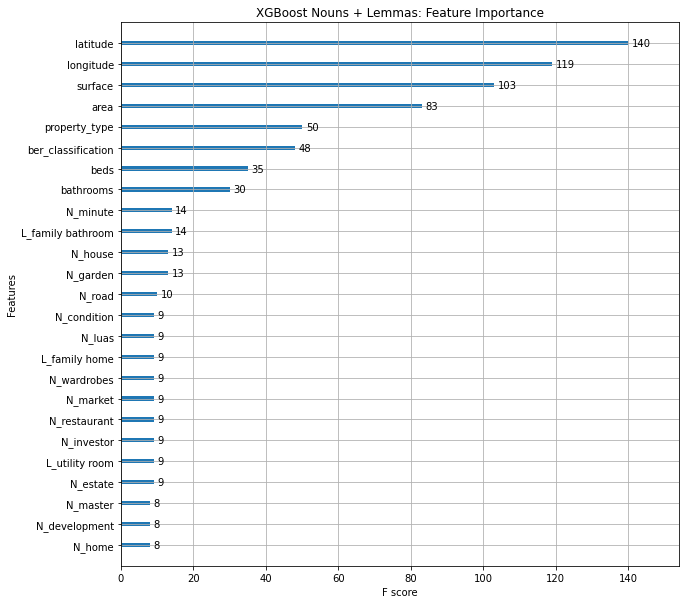

In [391]:
## plotting feature importance
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(xg_model, max_num_features=25,ax=ax, title= 'XGBoost Nouns + Lemmas: Feature Importance')
plt.savefig('feat_imp1.jpg')

AttributeError: 'DataFrame' object has no attribute 'predicted_price'

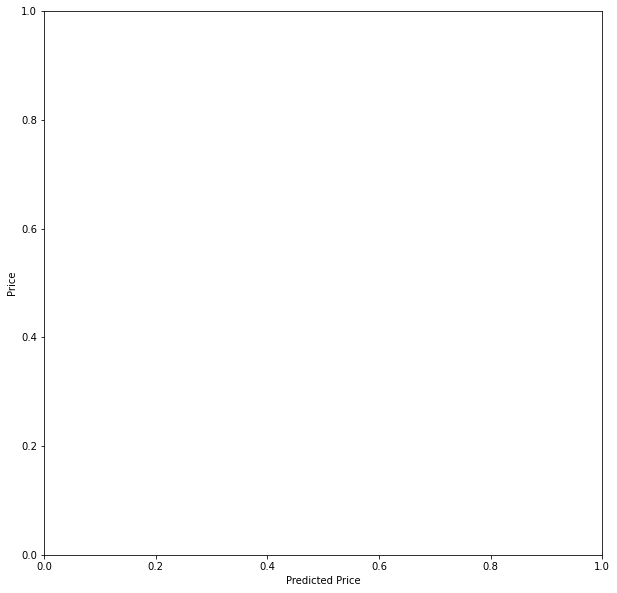

In [413]:
plt.figure(figsize=(10,10))
plt.ylabel(ylabel="Price") #plt.xlabel(s="Price")
plt.xlabel(xlabel="Predicted Price") #plt.ylabel(s="Predicted Price")
plt.scatter(y=test.price, x=test.predicted_price)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.title('Price vs. Predicted Price')
    
# Plot 45 degree line - the closer the data points to the line the better
plt.plot([0,1250000], [0,1250000], color='C3')

plt.savefig('scatterplot.jpg')

In [407]:
xg_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9648577280485036,
             eta=0.24776155091121366, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.247761548, max_delta_step=0, max_depth=5,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.5197681024467904, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [440]:
format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(xg_model, num_trees=xg_model.get_booster().best_iteration, rankdir='LR',  leaf_node_params={'shape': 'box',
 'style': 'filled',
 'fillcolor': '#e48038'})

#Set a different dpi (work only if format == 'png')
image.graph_attr = {'dpi':'400'}

image.render('xgbtree', format = format)

'xgbtree.png'

## OLS Baseline

In [353]:
## creates a regular regression model
OLS_reg = LinearRegression().fit(X_train, Y_train)
# predictions for training data (OLS Regression)
f.make_predictions(train, X_train, OLS_reg)
f.make_predictions(test, X_test, OLS_reg)
train_OLS1 = np.corrcoef(train['price'], train['predicted_price'])
train_OLS2 = train_OLS1[0,1]
train_OLS3 = train_OLS2**2 ## R-Squared

test_OLS1 = np.corrcoef(test['price'], test['predicted_price'])
test_OLS2 = test_OLS1[0,1]
test_OLS3 = test_OLS2**2 ## R-Squared
OLS_everything ={
    'Test MdAPE': f.MdAPE(test['price'], test['predicted_price']),
    'Test MAPE': f.MAPE(test['price'], test['predicted_price']),
    'Test MAE': MAE(test['price'], test['predicted_price']),
    'Test R-Squared': test_OLS3
}
## Accuracy Measures for Train and Testing Data (OLS Regression)
print('OLS Training MdAPE: ', f.MdAPE(train['price'], train['predicted_price']), '%')
print('OLS Training MAPE: ', f.MAPE(train['price'], train['predicted_price']), '%')

print('OLS Testing MdAPE: ', f.MdAPE(test['price'], test['predicted_price']), '%')
print('OLS Testing MAPE: ', f.MAPE(test['price'], test['predicted_price']), '%')

OLS Training MdAPE:  13.53 %
OLS Training MAPE:  17.02 %
OLS Testing MdAPE:  14.22 %
OLS Testing MAPE:  17.47 %


In [354]:
OLS_everything

{'Test MdAPE': 14.22,
 'Test MAPE': 17.47,
 'Test MAE': 72541.52749517138,
 'Test R-Squared': 0.7098338240218721}

In [399]:
XGResults

,Test MdAPE,Test MAPE,Test MAE,Test R-Squared
Structured (Base),9.75,13.07,53415.799698,0.823184
Base + Nouns,11.52,14.91,61009.861364,0.771783
Base + Adjectives,11.11,15.14,64287.031795,0.740594
Base + Lemmas,11.07,14.15,56941.401919,0.804613
Base + Nouns + Adjectives,11.88,15.84,63700.737006,0.770528
Base + Nouns + Lemmas,8.69,11.6,47365.428003,0.867498
Base + Adjectives + Lemmas,48.87,48.68,217807.034603,0.745451
Base + All,8.85,11.7,47202.337943,0.86449
Base + Counts + Lengths,9.45,12.1,51336.540458,0.834104


<AxesSubplot:>

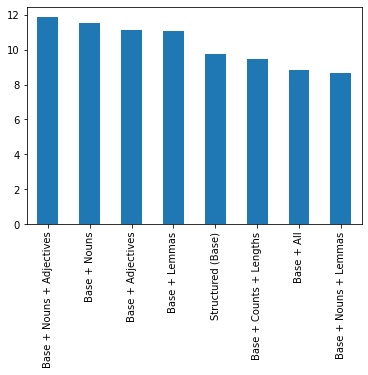

In [401]:
XGResults['Test MdAPE'].sort_values(ascending=False).drop(['Base + Adjectives + Lemmas'], axis=0).plot(kind='bar')

## Random Forest

### hyper tuning

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
model = RandomForestRegressor()
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {
         'max_depth' : hp.quniform('max_depth',3,8,1),
         #'max_features' : hp.choice('max_features',['auto','sqrt','log2']),
         #'min_samples_leaf' : hp.quniform('min_samples_leaf',2,6,2),
         'min_samples_split' : hp.quniform('min_samples_split',1,10,1),
         #'n_estimators': 100
}

def objective(space):
    reg = RandomForestRegressor(
                                    max_depth = space['max_depth'],
                                    max_features = 'auto',
                                    #min_samples_leaf = space['min_samples_leaf'],
                                    min_samples_split = int(space['min_samples_split']),
                                    n_estimators = 1000
    )

    model = reg.fit(X_train, Y_train
                     #eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     #early_stopping_rounds = 10,
                     #verbose = 0
                     )

    pred = reg.predict(X_train)
    accuracy = mean_absolute_error(Y_train, pred>0.5)
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [ ]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=100,
            trials=trials
           )

In [39]:
best_hyperparams

{'max_depth': 7.0,
 'max_features': 1,
 'min_samples_leaf': 0.43535186838724543,
 'min_samples_split': 0.5462263534070548}

### not hypertuning

In [422]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])
best_hyperparams['max_features'] = 'auto'

In [356]:
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=5)
rf_model=rf_model.fit(X_train, Y_train)#, #eval_metric='rmse',eval_set = [(X_test, Y_test)],
                                #early_stopping_rounds = 10, verbose=0

In [357]:
# predictions for training data 
f.make_predictions(train, X_train, rf_model)
f.make_predictions(test, X_test, rf_model)

In [358]:
RF1 = np.corrcoef(train['price'], train['predicted_price'])
RF2 = RF1[0,1]
RF3 = RF2**2

RF4 = np.corrcoef(test['price'], test['predicted_price'])
RF5 = RF4[0,1]
RF6 = RF5**2

In [359]:
RF_everything ={
    'Test MdAPE': f.MdAPE(test['price'], test['predicted_price']),
    'Test MAPE': f.MAPE(test['price'], test['predicted_price']),
    'Test MAE': MAE(test['price'], test['predicted_price']),
    'Test R-Squared': RF6
}

In [360]:
## Accuracy Measures for Train and Testing Data
print('Training')
print('MdAPE:', f.MdAPE(train['price'], train['predicted_price']), '%')
print('MAPE:', f.MAPE(train['price'], train['predicted_price']), '%')
print('R-Squared:', round(RF3, 4))
print('--------------------------------------', '\n')
print('Testing')
print('MdAPE:', f.MdAPE(test['price'], test['predicted_price']), '%')
print('MAPE:', f.MAPE(test['price'], test['predicted_price']), '%')
print('R-Squared:', RF6)

Training
MdAPE: 12.8 %
MAPE: 15.47 %
R-Squared: 0.7625
-------------------------------------- 

Testing
MdAPE: 13.84 %
MAPE: 16.77 %
R-Squared: 0.7391173710768566


In [361]:
RF_everything

{'Test MdAPE': 13.84,
 'Test MAPE': 16.77,
 'Test MAE': 69226.73019479278,
 'Test R-Squared': 0.7391173710768566}

## Results Comparison

In [330]:
def create_results(a,b,c,d,e,f,g,h,i):
    a,b,c = pd.DataFrame.from_dict(a.items()).transpose(), pd.DataFrame.from_dict(b.items()).transpose(), pd.DataFrame.from_dict(c.items()).transpose(),
    d,e,f = pd.DataFrame.from_dict(d.items()).transpose(), pd.DataFrame.from_dict(e.items()).transpose(), pd.DataFrame.from_dict(f.items()).transpose()
    g,h,i = pd.DataFrame.from_dict(g.items()).transpose(), pd.DataFrame.from_dict(h.items()).transpose(), pd.DataFrame.from_dict(i.items()).transpose()
    a.columns, b.columns, c.columns = a.iloc[0], b.iloc[0], c.iloc[0]
    d.columns, e.columns, f.columns = d.iloc[0], e.iloc[0], f.iloc[0]
    g.columns, h.columns, i.columns = g.iloc[0], h.iloc[0], i.iloc[0]
    a,b,c,d,e,f,g,h,i = a[1:], b[1:], c[1:], d[1:], e[1:], f[1:], g[1:], h[1:], i[1:]

    frames = [a,b,c,d,e,f,g,h,i]
    results = pd.concat(frames)
    results.index = ['Structured (Base)', 'Base + Nouns', 'Base + Adjectives', 'Base + Lemmas','Base + Nouns + Adjectives', 'Base + Nouns + Lemmas', 'Base + Adjectives + Lemmas', 'Base + All', 'Base + Counts + Lengths']
    return results

In [324]:
XGBoost_none = {
        'Test MdAPE':9.75,   
        'Test MAPE':13.07,
        'Test MAE':53415.799698,
        'Test R-Squared':0.823184
}

In [337]:
RF_results = create_results(RF_none, RF_nouns, RF_adj, RF_lemma, RF_nouns_adj, RF_nouns_lemmas, RF_adj_lemmas,RF_all, RF_counts)

In [338]:
RF_results

,Test MdAPE,Test MAPE,Test MAE,Test R-Squared
Structured (Base),14.18,16.82,69051.498074,0.737549
Base + Nouns,13.96,16.75,68901.3127,0.741373
Base + Adjectives,14.32,16.83,69166.950322,0.735742
Base + Lemmas,14.02,16.75,68880.990195,0.738663
Base + Nouns + Adjectives,13.89,16.69,68778.860843,0.74267
Base + Nouns + Lemmas,14.05,16.71,68718.5858,0.743114
Base + Adjectives + Lemmas,14.12,16.77,68985.940344,0.738639
Base + All,14.31,16.7,68630.957537,0.74463
Base + Counts + Lengths,13.89,16.8,69361.148046,0.735104


In [339]:
RF_results.to_csv('rfsresults.csv')

In [367]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'].head(25), y=fi_df['feature_names'].head(25))
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

<AxesSubplot:title={'center':'XGBoost Relative Feature Importance'}, xlabel='F score', ylabel='Features'>

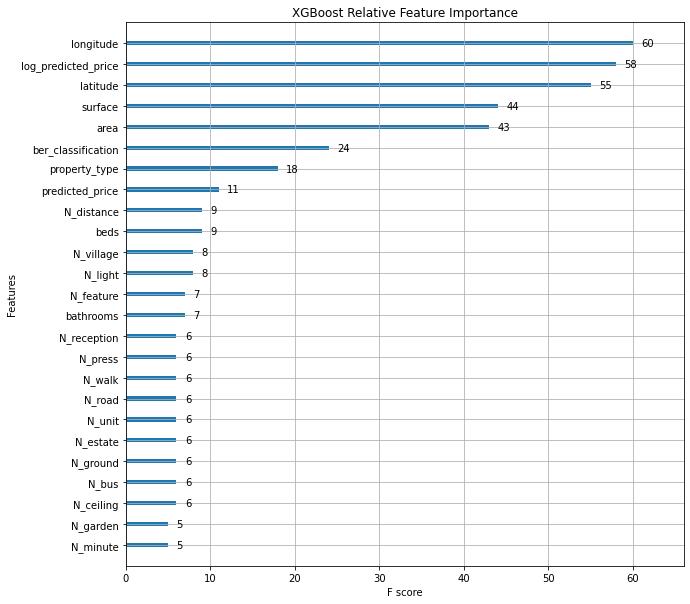

In [430]:
## plotting feature importance
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(xg_model, max_num_features=25,ax=ax, title='XGBoost Relative Feature Importance')

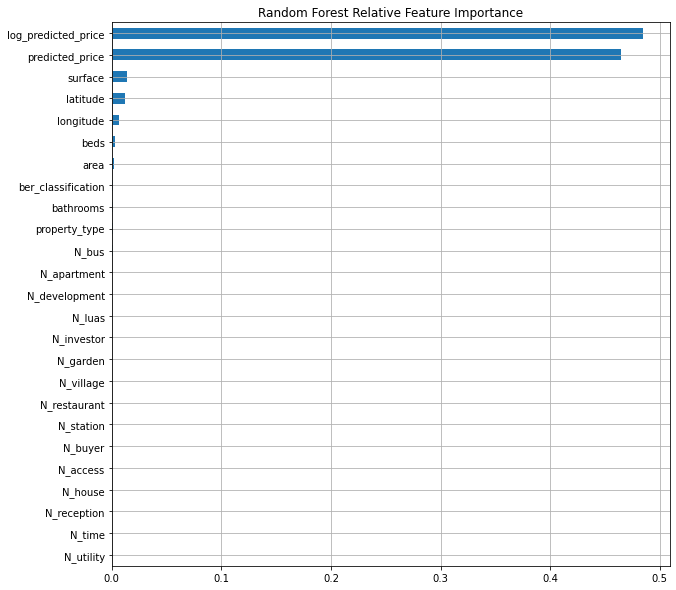

In [431]:
fig = plt.figure(figsize=(10,10))
plt.title('Random Forest Relative Feature Importance')
feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh', grid=True).invert_yaxis()

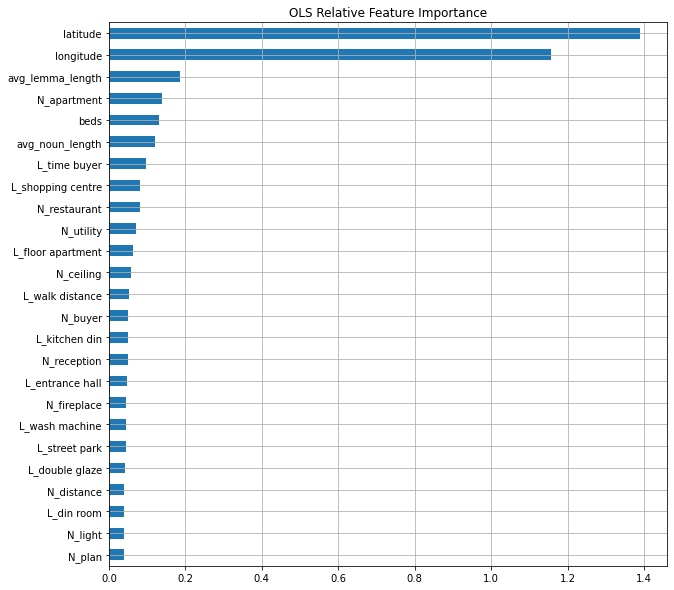

In [392]:
fig = plt.figure(figsize=(10,10))
plt.title('OLS Relative Feature Importance')
feat_importances = pd.Series(abs(OLS_reg.coef_), index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh', grid=True).invert_yaxis()

In [ ]:
format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model, num_trees=model.get_booster().best_iteration)

#Set a different dpi (work only if format == 'png')
image.graph_attr = {'dpi':'400'}

image.render('xgbtree', format = format)

In [393]:
dftrain.shape

(2434, 123)

# Question 2: Predicting Location

#### Number of Classes

In [36]:
dftrain['area'].value_counts()

63     90
115    83
25     73
92     70
135    69
       ..
14      1
39      1
2       1
23      1
46      1
Name: area, Length: 144, dtype: int64

In [37]:
vcounts = dftrain['area'].value_counts().to_frame()
vcounts = vcounts.rename(columns={'area': 'freq'})
print('% Areas with <=10 obs.:',round(len(vcounts[vcounts['freq']<=10])/len(vcounts)*100, 4),'%')
print('% Areas with >25 obs.:',round(len(vcounts[vcounts['freq']>25])/len(vcounts)*100, 4),'%')

% Areas with <=10 obs.: 45.1389 %
% Areas with >25 obs.: 18.75 %


[]

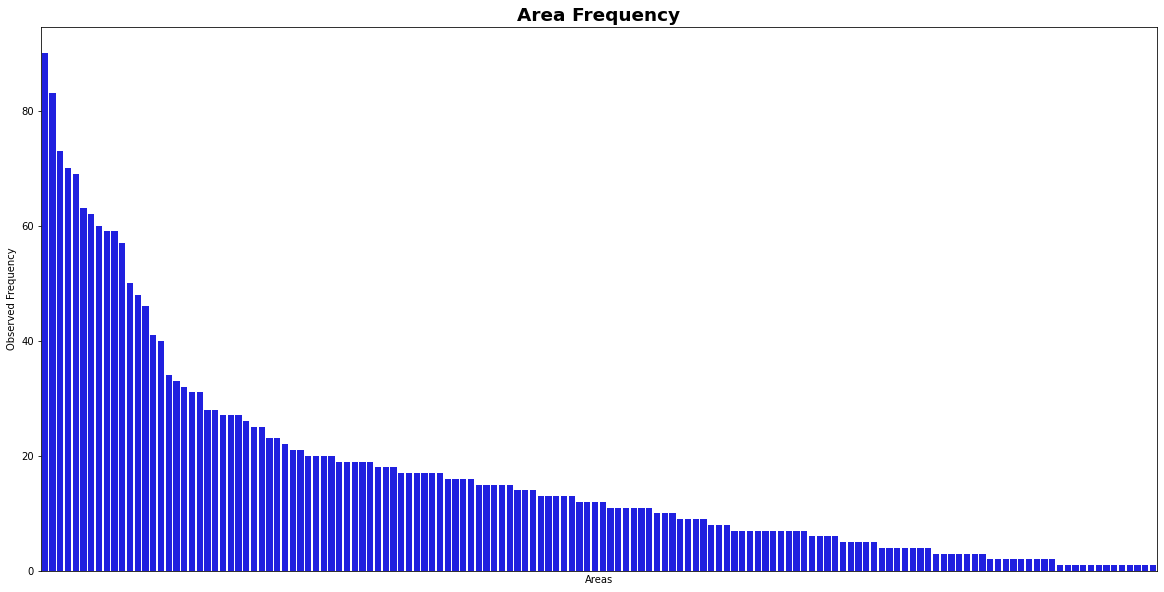

In [38]:
fig, axes = plt.subplots(1, figsize=(20,10), sharey=False)
sns.countplot(data=dftrain, x='area', color='b', order=dftrain['area'].value_counts().index).set(xlabel='Areas', ylabel='Observed Frequency')
axes.set_title('Area Frequency', weight='bold', fontsize=18.5)
axes.xaxis.set_ticks([])


## Prep Data

In [395]:
# define the model
dftrain = pd.read_csv("q2_dftrain.csv",index_col='ad_id')

In [41]:
dftrain.head()

,area,ber_classification,property_type,bathrooms,beds,latitude,longitude,price,surface,log_price,...,L_unit,L_upstairs,L_view,L_village,L_walk distance,L_wall,L_wardrobe,L_wardrobes,L_wash,L_window
ad_id,,,,,,,,,,,,,,,,,,,,,
11161103,92,17,3,1.0,1.0,53.353395,-6.458716,600000.0,0.0,13.304685,...,0,0,1,1,0,0,0,0,0,0
11185670,73,14,3,2.0,5.0,53.375467,-6.062246,980000.0,202.0,13.795308,...,0,1,1,0,0,0,0,0,0,0
11421934,24,16,3,2.0,3.0,53.246732,-6.174917,850000.0,150.0,13.652992,...,0,0,0,0,0,1,0,0,0,0
11487466,63,8,1,2.0,3.0,53.403799,-6.294608,230000.0,0.0,12.345835,...,0,0,0,1,0,0,0,0,0,0
11489764,63,10,1,2.0,2.0,53.402663,-6.294619,189950.0,0.0,12.154516,...,0,0,1,1,0,0,0,1,0,1


In [42]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)
## splitting the training dataset into a train and validation set
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 157)
Testing Data Rows and Columns: (487, 157)


In [43]:
X_train = train.drop(['area', 'latitude', 'longitude'], axis = 1)
Y_train = train['area']

X_test = test.drop(['area', 'latitude', 'longitude'], axis = 1)
Y_test = test['area']

In [44]:
print('Training Data Rows and Columns:','X',X_train.shape, 'Y',Y_train.shape)
print('Testing Data Rows and Columns:', 'X', X_test.shape, 'Y', Y_test.shape)

Training Data Rows and Columns: X (1947, 154) Y (1947,)
Testing Data Rows and Columns: X (487, 154) Y (487,)


## Multinomial Logistic Regression (4.2% Accuracy)

In [63]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.05)

In [64]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [65]:
# evaluate multinomial logistic regression model
from numpy import mean
from numpy import std
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.042 (0.008)


## Ensemble Methods

### Random Forest (12.6%)

In [104]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [ ]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {
         'max_depth' : hp.quniform('max_depth',3,10,1),
         'max_features' : hp.choice('max_features',['auto','sqrt','log2',None]),
         'min_samples_leaf' : hp.uniform('min_samples_leaf',0,0.5),
         'min_samples_split' : hp.uniform('min_samples_split',0,1),
         'n_estimators': hp.choice('n_estimators',[100])
}

In [ ]:
def objective(space):
    model = RandomForestClassifier( criterion = 'gini',
                                    max_depth = space['max_depth'],
                                    max_features = space['max_features'],
                                    min_samples_leaf = space['min_samples_leaf'],
                                    min_samples_split = space['min_samples_split'],
                                    n_estimators = space['n_estimators']
    )
    
    accuracy = cross_val_score(model, X_train,Y_train,cv=10).mean()
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=80,
            trials=trials
           )
best


In [ ]:
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix,classification_report

In [ ]:
trainedforest = RandomForestClassifier(criterion = 'gini', max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_train,Y_train)
predictionforest = trainedforest.predict(X_test)
print(confusion_matrix(Y_test,predictionforest))
print(accuracy_score(Y_test,predictionforest))
print(classification_report(Y_test,predictionforest))
acc5 = accuracy_score(Y_test,predictionforest)

In [ ]:
print(round(acc5*100, 3)

### XGBoost (6.34% Accuracy)

In [ ]:
int(Y_test[Y_test==77].index.values)

In [ ]:
X_test = X_test.drop([int(Y_test[Y_test==77].index.values)],axis=0)

In [ ]:
Y_test = Y_test[Y_test!=77]

In [ ]:
space={'max_depth': hp.quniform("max_depth", 5, 10, 1),
        #'gamma': hp.uniform ('gamma', 1,9),
        'eta' : hp.uniform('eta', 0.01, 0.5),
        #'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        #'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'subsample' : hp.uniform('subsample', 0.5, 0.8),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.4,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice('n_estimators',[100,500,1000]),
        'seed': 0
    }

In [ ]:
## Define a grid of potential values for each hyperparameter
def objective(space):
    clg = xgb.XGBClassifier(objective='multi:softmax',
                            booster='gbtree',
                            n_estimators =100, 
                            max_depth = int(space['max_depth']), 
                            #gamma = space['gamma'],
                            #reg_alpha = space['reg_alpha'],
                            #reg_lambda = space['reg_lambda'], 
                            eval_metric='merror',
                            eta = space['eta'], 
                            subsample = space['subsample'],
                            min_child_weight = space['min_child_weight'],
                            colsample_bytree=int(space['colsample_bytree']),
                            num_class = 143)
   
    model =  clg.fit(X_train, Y_train,
                     eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     early_stopping_rounds = 10,
                     verbose = 0)

    pred = clg.predict(X_train)
    #accuracy = accuracy_score(eval_data['log_price'], pred>0.5, normalize=False)
    accuracy = mean_absolute_error(Y_train, pred>0.5)
       
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                        )

In [ ]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'

In [ ]:
model = xgb.XGBClassifier(**best_hyperparams)
model=model.fit(X_train,Y_train, eval_metric='merror',eval_set = [(X_test, Y_test)],
                                 early_stopping_rounds = 10,
                                 verbose=0)

In [ ]:
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix,classification_report
Y_pred = model.predict(X_test)
#print(confusion_matrix(Y_test,Y_pred))
#print(accuracy_score(Y_test,Y_pred))
#print(classification_report(Y_test,Y_pred))
acc5 = accuracy_score(Y_test,Y_pred)
print(round(acc5*100, 3), '% Accuracy')

## Clustering Approaches

### KMeans

In [46]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [47]:
loc = dftrain[['longitude', 'latitude']]

kmeans_kwargs = {
            "init": "random",
            "n_init": 10,
            "max_iter": 300,
            "random_state": 42,
        }

        # A list holds the SSE values for each k
sse = []
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    clusters = kmeans.fit(loc).labels_
    column = str(k)+'_clusters'
    dftrain[column] = clusters

#### plotting clusters

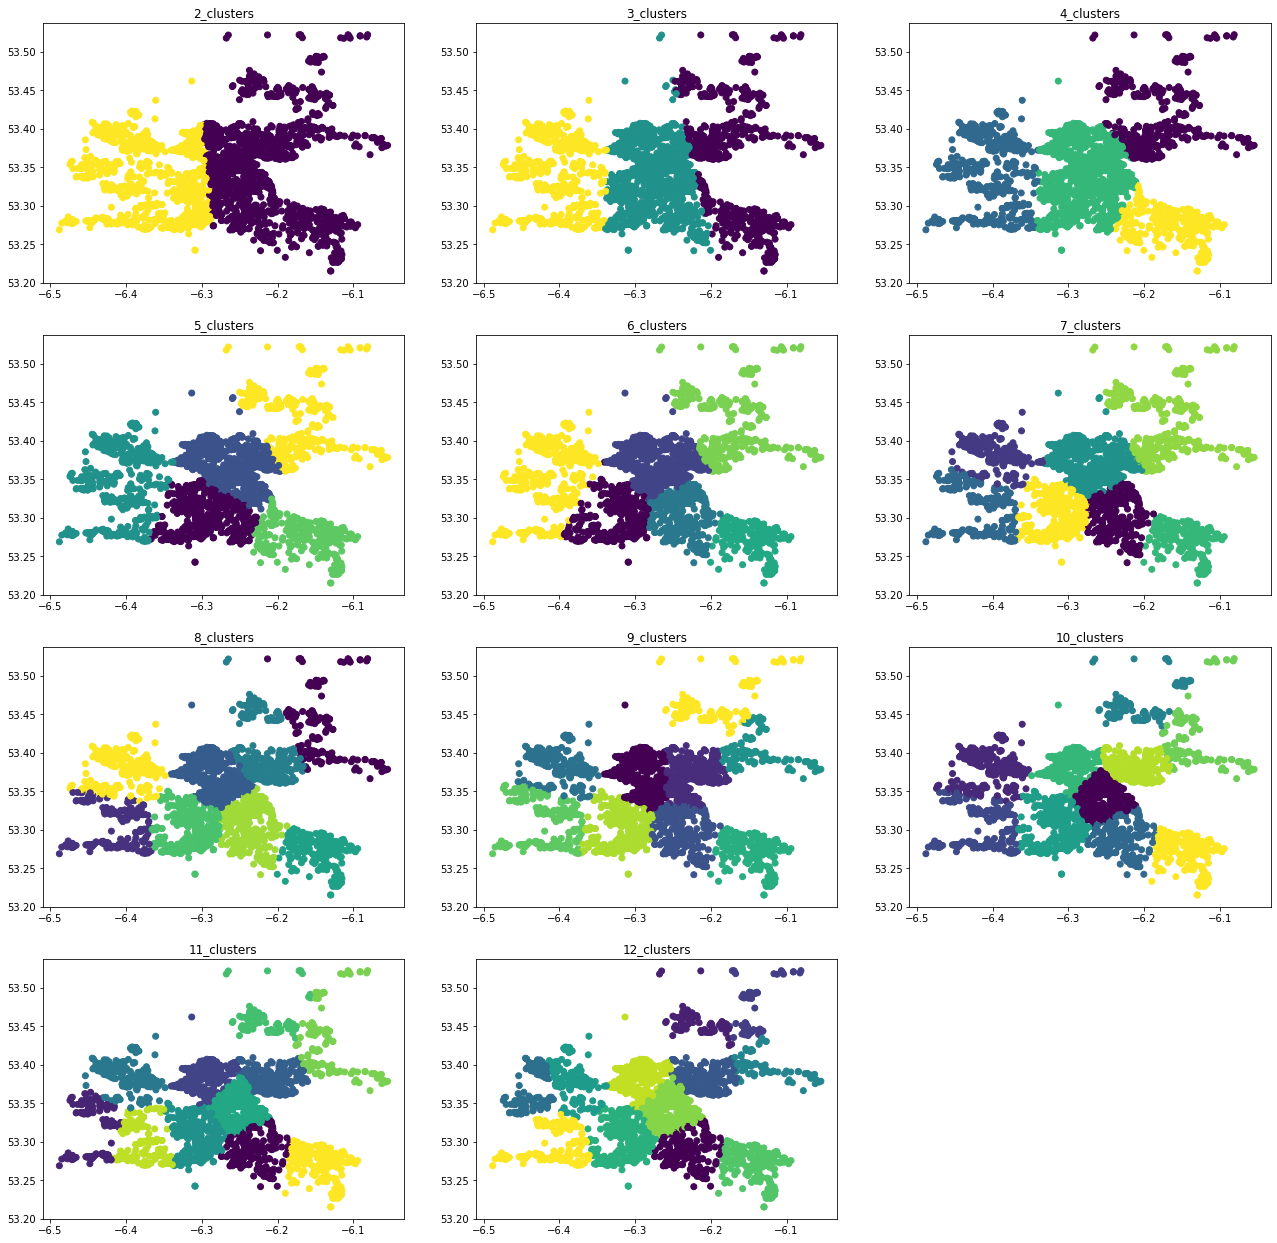

In [50]:
## plotting each variables relationship with Price Variable
plt.figure(figsize=(22,22))
columns = list(dftrain.columns[157:].values)
for i, column in enumerate(columns, 1):
    plt.subplot(4,3,i)
    plt.title(label=column)
    plt.scatter(dftrain['longitude'], dftrain['latitude'], c=dftrain[column]) 
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)

plt.savefig('clusters.jpg')

##### Training data prep

In [52]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)
## splitting the training dataset into a train and validation set
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 168)
Testing Data Rows and Columns: (487, 168)


##### Multi-nomial Logistic Regression

In [53]:
from numpy import mean

In [60]:
#### Granularity vs Predictive Accuracy
def gran_vs_acc(dftrain, train, test):
    results = []
    cluster_cols = list(dftrain.columns[157:].values)
    drop_columns = ['area', 'latitude', 'longitude']+cluster_cols

    X_train = train.drop(drop_columns, axis = 1)
    X_test = test.drop(drop_columns, axis = 1)
    
    for col in cluster_cols:
        Y_train = train[col] 
        Y_test = test[col]

        model = LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty = 'l2', C=0.5)

        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluate the model and collect the scores
        n_scores = cross_val_score(model, X_test, Y_test, scoring='accuracy', cv=cv, n_jobs=-1)
        results.append([col,
                        (mean(n_scores))])
        print(col, 'done')
    
    results = pd.DataFrame(results, columns=['n_clusters', 'accuracy'])
    return results

In [61]:
results = gran_vs_acc(dftrain, train, test)

2_clusters done
3_clusters done
4_clusters done
5_clusters done
6_clusters done
7_clusters done
8_clusters done
9_clusters done
10_clusters done
11_clusters done
12_clusters done


In [62]:
results.to_csv('mlogreg_nclust_results.csv')

In [63]:
results

,n_clusters,accuracy
0,2_clusters,0.720748
1,3_clusters,0.582568
2,4_clusters,0.576956
3,5_clusters,0.495011
4,6_clusters,0.485091
5,7_clusters,0.461990
6,8_clusters,0.429351
7,9_clusters,0.370408
8,10_clusters,0.421032
9,11_clusters,0.390037


In [72]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty = 'l2', C=0.5)
model = model.fit(X_train, Y_train)

<Figure size 720x720 with 0 Axes>

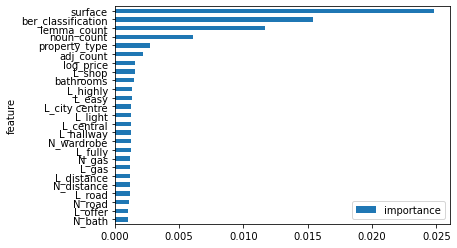

In [85]:
feature_names = X_train.columns
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = abs(model.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)


from sklearn.linear_model import LogisticRegression
fig = plt.figure(figsize=(10,10))
feature_importance.nlargest(25, 'importance').plot.barh(x='feature', y='importance').invert_yaxis()
plt.show()

##### SELECT N_CLUSTERS FOR RF AND XGB

In [248]:
## CHOOSE N HERE
n = 6
n_clusters = str(n)+'_clusters'

In [249]:
cluster_cols = list(dftrain.columns[157:].values)
drop_columns = ['area', 'latitude', 'longitude']+cluster_cols

In [269]:
X_train = train.drop(drop_columns+counts_lengths, axis = 1)
Y_train = train[n_clusters] ## set this to n_clusters

X_test = test.drop(drop_columns+counts_lengths, axis = 1)
Y_test = test[n_clusters] ## set this to n_clusters

##### Random Forest

In [219]:
# define the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [110]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {
         'max_depth' : hp.quniform('max_depth',3,10,1),
         'max_features' : hp.choice('max_features',['auto','sqrt','log2',None]),
         'min_samples_leaf' : hp.uniform('min_samples_leaf',0,0.5),
         'min_samples_split' : hp.uniform('min_samples_split',0,1),
         'n_estimators': hp.choice('n_estimators',[500])
}

In [111]:
def objective(space):
    model = RandomForestClassifier( criterion = 'gini',
                                    max_depth = space['max_depth'],
                                    max_features = space['max_features'],
                                    min_samples_leaf = space['min_samples_leaf'],
                                    min_samples_split = space['min_samples_split'],
                                    n_estimators = space['n_estimators']
    )
    
    accuracy = cross_val_score(model, X_train,Y_train,cv=10).mean()
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=80,
            trials=trials
           )
best

In [95]:
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}

In [228]:
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix,classification_report
trainedforest = RandomForestClassifier(criterion = 'gini', max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = 500).fit(X_train,Y_train)
predictionforest = trainedforest.predict(X_test)
#print(confusion_matrix(Y_test,predictionforest))
#print(accuracy_score(Y_test,predictionforest))
#print(classification_report(Y_test,predictionforest))
acc5 = accuracy_score(Y_test,predictionforest)
print(acc5, '% Accuracy')

0.3757700205338809 % Accuracy


##### XGBoost

In [259]:
space={'max_depth': hp.quniform("max_depth", 5, 10, 1),
        #'gamma': hp.uniform ('gamma', 1,9),
        'eta' : hp.uniform('eta', 0.01, 0.5),
        #'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        #'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'subsample' : hp.uniform('subsample', 0.5, 0.8),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.4,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 0
    }

In [260]:
## Define a grid of potential values for each hyperparameter
def objective(space):
    clg = xgb.XGBClassifier(objective='multi:softmax',
                            booster='gbtree',
                            n_estimators =1000, 
                            max_depth = int(space['max_depth']), 
                            #gamma = space['gamma'],
                            #reg_alpha = space['reg_alpha'],
                            #reg_lambda = space['reg_lambda'], 
                            eval_metric='merror',
                            eta = space['eta'], 
                            subsample = space['subsample'],
                            min_child_weight = space['min_child_weight'],
                            colsample_bytree=int(space['colsample_bytree']),
                            num_class = n+1)
   
    model =  clg.fit(X_train, Y_train,
                     eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     early_stopping_rounds = 10,
                     verbose = 0)

    pred = clg.predict(X_train)
    #accuracy = accuracy_score(eval_data['log_price'], pred>0.5, normalize=False)
    accuracy = mean_absolute_error(Y_train, pred>0.5)
       
    return {'loss': -accuracy, 'status': STATUS_OK }

In [261]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                        )

100%|██████████| 100/100 [00:19<00:00,  5.17trial/s, best loss: -1.6240369799691834]


In [262]:
best_hyperparams

{'colsample_bytree': 0.8927862270652558,
 'eta': 0.38849178369719856,
 'max_depth': 6.0,
 'min_child_weight': 2.0,
 'subsample': 0.5303637386404708}

In [263]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])

In [270]:
model = xgb.XGBClassifier(**best_hyperparams, n_estimators=500)
model=model.fit(X_train,Y_train, eval_metric='merror',eval_set = [(X_test, Y_test)],
                                 early_stopping_rounds = 10,
                                 verbose=0)

In [271]:
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix,classification_report
Y_pred = model.predict(X_test)
#print(confusion_matrix(Y_test,Y_pred))
#print(accuracy_score(Y_test,Y_pred))
#print(classification_report(Y_test,Y_pred))
acc5 = accuracy_score(Y_test,Y_pred)
print(acc5, '% Accuracy')

0.6057494866529775 % Accuracy


In [268]:
counts_lengths = ['lemma_count', 'avg_lemma_length']+['noun_count', 'avg_noun_length']+['adj_count', 'avg_adj_length']

In [ ]:
adj_dtm

<AxesSubplot:title={'center':'XGBoost: Feature Importance'}, xlabel='F score', ylabel='Features'>

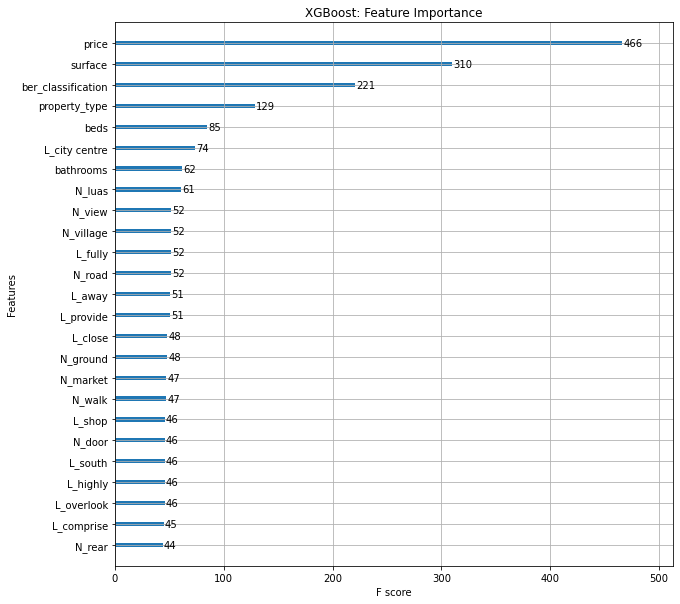

In [272]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, max_num_features=25,ax=ax, title= 'XGBoost: Feature Importance')

## ANNs

In [358]:
from keras.models import Model
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow import keras
from keras import layers
from numpy import array
from numpy.random import uniform
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

In [359]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [360]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)
## splitting the training dataset into a train and validation set
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 168)
Testing Data Rows and Columns: (487, 168)


In [361]:
X_train = train.drop(['area', 'latitude', 'longitude']+counts_lengths, axis = 1).to_numpy()
Y_train = train[['latitude', 'longitude']].to_numpy()

X_test = test.drop(['area', 'latitude', 'longitude']+counts_lengths, axis = 1).to_numpy()
Y_test = test[['latitude', 'longitude']].to_numpy()

In [362]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(2))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [363]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=5)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold)

array([[17.,  1.,  1., ...,  0.,  6.,  9.],
       [13.,  9.,  2., ...,  9., 10.,  8.],
       [ 9.,  6.,  3., ...,  1.,  4.,  4.],
       ...,
       [11.,  6.,  1., ...,  3.,  0.,  0.],
       [15.,  6.,  1., ...,  9., 10.,  8.],
       [ 9.,  6.,  3., ...,  2.,  9., 11.]])

In [382]:
def build_regressor(hp):
    model = Sequential(
        [
            layers.Dense(units=hp.Int("units", 32, 128, 32), input_dim=159, activation="relu"),
            layers.Dense(units=2),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        # Objective is one of the metrics.
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model

In [383]:
import keras_tuner as kt
tuner = kt.RandomSearch(
    hypermodel=build_regressor,
    # The objective name and direction.
    # Name is the f"val_{snake_case_metric_class_name}".
    objective=kt.Objective("val_mean_absolute_error", direction="min"),
    max_trials=3,
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [384]:
tuner.search(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test))

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_models()

In [379]:
tuner.get_best_models()

ValueError: Shapes (2,) and (1,) are incompatible

y1 MAE:72.7840
y2 MAE:200.6047


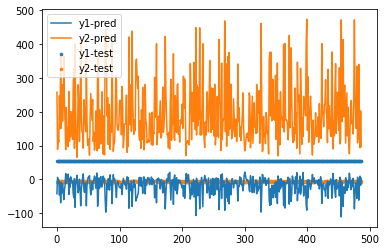

In [394]:
ypred = model.predict(X_test)
print("y1 MAE:%.4f" % mean_absolute_error(Y_test[:,0], ypred[:,0]))
print("y2 MAE:%.4f" % mean_absolute_error(Y_test[:,1], ypred[:,1]))

x_ax = range(len(X_test))
plt.scatter(x_ax, Y_test[:,0],  s=6, label="y1-test")
plt.plot(x_ax, ypred[:,0], label="y1-pred")
plt.scatter(x_ax, Y_test[:,1],  s=6, label="y2-test")
plt.plot(x_ax, ypred[:,1], label="y2-pred")
plt.legend()
plt.show()

## MultiOutputRegressor vs RandomForest Multi-Output

In [396]:
## splitting the training dataset into a train and validation set
train, test = train_test_split(dftrain, test_size=0.2)
## splitting the training dataset into a train and validation set
print('Training Data Rows and Columns:',train.shape)
print('Testing Data Rows and Columns:',test.shape)

Training Data Rows and Columns: (1947, 157)
Testing Data Rows and Columns: (487, 157)


In [433]:
X_train = train.drop(['area', 'latitude', 'longitude']+counts_lengths+['log_price', 'N_luas'], axis = 1)
Y_train = train[['latitude', 'longitude']] ## set this to n_clusters

X_test = test.drop(['area', 'latitude', 'longitude']+counts_lengths+['log_price', 'N_luas'], axis = 1)
Y_test = test[['latitude', 'longitude']] ## set this to n_clusters

In [399]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
model = RandomForestRegressor()

In [287]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {
         'max_depth' : hp.quniform('max_depth',3,10,1),
         #'max_features' : hp.choice('max_features',['auto','sqrt','log2',None]),
         #'min_samples_leaf' : hp.uniform('min_samples_leaf',0,0.5),
         #'min_samples_split' : hp.uniform('min_samples_split',0,1),
         #'n_estimators': 100
}

In [288]:
def objective(space):
    reg = MultiOutputRegressor(RandomForestRegressor(
                                    max_depth = space['max_depth'],
                                    #max_features = space['max_features'],
                                    #min_samples_leaf = space['min_samples_leaf'],
                                    #min_samples_split = space['min_samples_split'],
                                    n_estimators = 500
    ))

    model = reg.fit(X_train, Y_train
                     #eval_set = [(X_train, Y_train),(X_test, Y_test)],
                     #early_stopping_rounds = 10,
                     #verbose = 0
                     )

    pred = reg.predict(X_train)
    accuracy = mean_absolute_error(Y_train, pred>0.5)
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [ ]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=80,
            trials=trials
           )

In [400]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
#best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])

In [434]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=500, max_depth=20))
model=model.fit(X_train, Y_train)
#eval_metric='rmse',eval_set = [(X_test, Y_test)],
#       early_stopping_rounds = 10, verbose=0
#, #eval_metric='rmse',eval_set = [(X_test, Y_test)],
                                #
                                

In [435]:
lat_pred = model.predict(X_test)[:,0]
long_pred = model.predict(X_test)[:,1]

lat_true = Y_test.latitude
long_true = Y_test.longitude

In [403]:
XGB1 = np.corrcoef(lat_true, lat_pred)
XGB2 = XGB1[0,1]
XGB3 = XGB2**2

XGB4 = np.corrcoef(long_true, long_pred)
XGB5 = XGB4[0,1]
XGB6 = XGB5**2

print('Latitude MdAPE:', f.MdAPE(lat_true, lat_pred))
print('Latitude MAPE:', f.MAPE(lat_true, lat_pred))
print('Latitude MAE:', MAE(lat_true, lat_pred))
print('Latitude R-Squared:', XGB3)
print('----------------------------------------------')
print('Longitude MdAPE:', f.MdAPE(long_true, long_pred))
print('Longitude MAPE:', f.MAPE(long_true, long_pred))
print('Longitude MAE:', MAE(long_true, long_pred))
print('Longitude R-Squared:', XGB6)

Latitude MdAPE: 0.04
Latitude MAPE: 0.06
Latitude MAE: 0.029756707819369354
Latitude R-Squared: 0.49465129901661736
----------------------------------------------
Longitude MdAPE: 0.7
Longitude MAPE: 0.87
Longitude MAE: 0.05439466379504042
Longitude R-Squared: 0.40798713242880874


In [421]:
loc_pred = pd.DataFrame(model.predict(X_test), columns = ['predicted_latitude', 'predicted_longitude'])
loc_pred.index = loc_true.index
loc_true = Y_test

,latitude,longitude,predicted_latitude,predicted_longitude
ad_id,,,,
11489764,NaN,NaN,NaN,NaN
11541409,NaN,NaN,NaN,NaN
11574531,NaN,NaN,NaN,NaN
11590259,NaN,NaN,NaN,NaN
11763583,NaN,NaN,NaN,NaN
...,...,...,...,...
12428035,NaN,NaN,NaN,NaN
12428232,NaN,NaN,NaN,NaN
12428240,NaN,NaN,NaN,NaN


In [415]:
loc_comp

,latitude,longitude,predicted_latitude,predicted_longitude
ad_id,,,,
11489764,53.402663,-6.294619,NaN,NaN
11541409,NaN,NaN,53.392448,-6.307195
11574531,NaN,NaN,53.339554,-6.206700
11590259,53.399592,-6.276004,NaN,NaN
11763583,53.352197,-6.249821,53.353695,-6.320995
...,...,...,...,...
12428035,53.399355,-6.428349,NaN,NaN
12428232,53.338738,-6.237199,NaN,NaN
12428240,53.335793,-6.294268,NaN,NaN


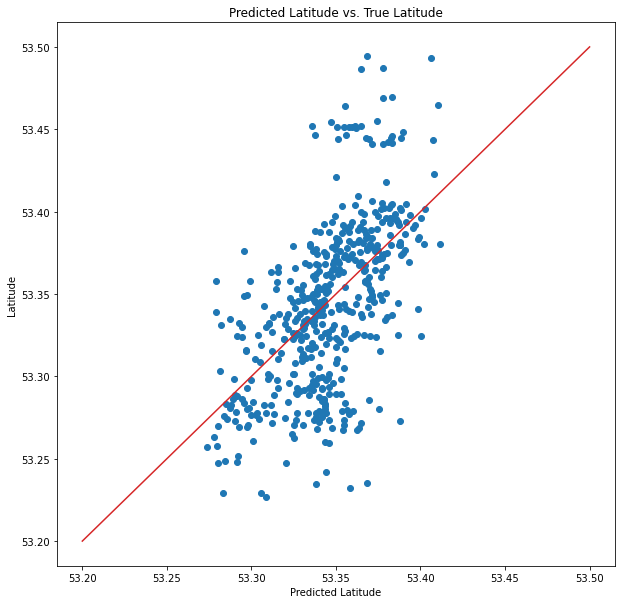

In [356]:
plt.figure(figsize=(10,10))
plt.ylabel(ylabel="Latitude") #plt.xlabel(s="Price")
plt.xlabel(xlabel="Predicted Latitude") #plt.ylabel(s="Predicted Price")
plt.scatter(y=loc_comp.latitude, x=loc_comp.predicted_latitude)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
#plt.title('Price vs. Predicted Price')
    
# Plot 45 degree line - the closer the data points to the line the better
plt.plot([53.2,53.5], [53.2,53.5], color='C3')
plt.title('Predicted Latitude vs. True Latitude')
plt.savefig('lat_R.jpg')

In [344]:
import folium
from folium import Map
from folium.plugins import HeatMap
from IPython.display import display_html
from itertools import chain,cycle

In [ ]:
import folium
import pandas as pd

#create a map
this_map = folium.Map(prefer_canvas=True)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[loc_comp.latitude, loc_comp.longitude],
                        radius=2,
                        weight=5).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
loc_comp[['latitude', 'longitude']].apply(plotDot, axis=1)


#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())

this_map

,L_apartment,L_away,L_bath,L_bright,L_build,L_bus,L_bus route,L_central,L_city centre,L_close,...,L_unit,L_upstairs,L_view,L_village,L_walk distance,L_wall,L_wardrobe,L_wardrobes,L_wash,L_window
ad_id,,,,,,,,,,,,,,,,,,,,,
11161103,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
11185670,0,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
11421934,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11487466,1,0,1,1,0,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0
11489764,1,0,0,0,0,1,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12428232,1,0,0,1,1,0,0,0,1,1,...,1,0,1,1,1,1,1,0,1,0
12428240,0,0,1,0,1,0,0,1,1,1,...,1,0,0,0,0,1,1,0,1,1
12428247,1,1,1,1,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,0


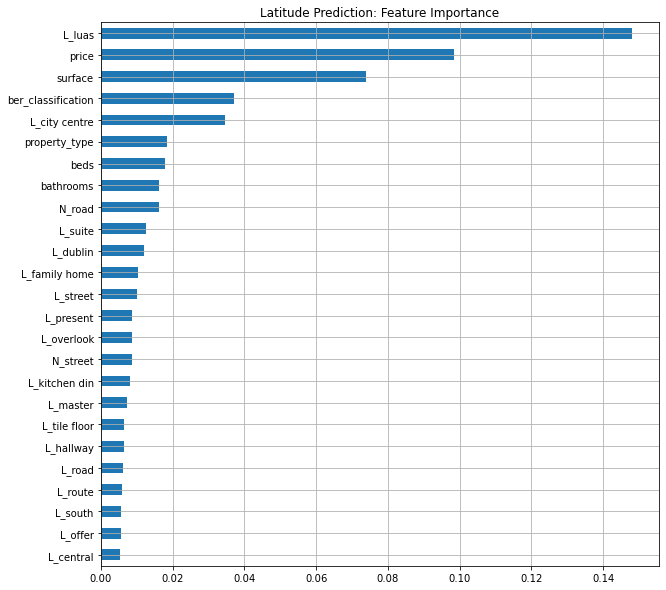

In [440]:
fig = plt.figure(figsize=(10,10))
plt.title('Latitude Prediction: Feature Importance')
feat_importances = pd.Series(model.estimators_[0].feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh', grid=True).invert_yaxis()